In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
import scipy.stats
import numpy as np
from math import sqrt
from matplotlib.pyplot import cm
import json
import re
from scipy.spatial import distance

In [2]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [3]:
# Load the flow data
flowdata = pd.read_csv('/Users/victoriachen/Documents/Simulation/Assessment/london_flows.csv')
print(flowdata.head())


  station_origin station_destination  flows  population   jobs     distance
0     Abbey Road   Bank and Monument      0         599  78549  8131.525097
1     Abbey Road             Beckton      1         599    442  8510.121774
2     Abbey Road           Blackwall      3         599    665  3775.448872
3     Abbey Road        Canary Wharf      1         599  58772  5086.514220
4     Abbey Road        Canning Town     37         599  15428  2228.923167


In [4]:
int(flowdata["flows"].max())

15946

In [5]:
int(flowdata["distance"].max())

60633

### wrangling data

In [6]:
# create pivot table to better show the flows between each origin and destination
pivot_flows = pd.pivot_table(flowdata, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
pivot_flows

/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/2289485014.py:2: FutureWarning: The provided callable <function sum at 0x1202e55e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_flows = pd.pivot_table(flowdata, values ="flows", index="station_origin", columns = "station_destination",
/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/2289485014.py:2: FutureWarning: The provided callable <function sum at 0x1202e55e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_flows = pd.pivot_table(flowdata, values ="flows", index="station_origin", columns = "station_destination",
/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/2289485014.py:2: FutureWarning: The provided callable <functi

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [7]:
flowdata = flowdata[flowdata['distance'] != 0].reset_index(drop=True)

In [8]:
flowdata = flowdata.dropna()

In [9]:
print(flowdata)

         station_origin station_destination  flows  population   jobs  \
0            Abbey Road   Bank and Monument      0         599  78549   
1            Abbey Road             Beckton      1         599    442   
2            Abbey Road           Blackwall      3         599    665   
3            Abbey Road        Canary Wharf      1         599  58772   
4            Abbey Road        Canning Town     37         599  15428   
...                 ...                 ...    ...         ...    ...   
61451  Woolwich Arsenal       Tower Gateway    127        7892   3342   
61452  Woolwich Arsenal            West Ham    608        7892   5487   
61453  Woolwich Arsenal     West India Quay      6        7892    400   
61454  Woolwich Arsenal     West Silvertown     81        7892    893   
61455  Woolwich Arsenal           Westferry     76        7892   1250   

           distance  
0       8131.525097  
1       8510.121774  
2       3775.448872  
3       5086.514220  
4       2228.

In [10]:
print(flowdata['distance'].describe())
print(f"Remaining rows: {len(flowdata)}")

zero_dist_rows = flowdata[flowdata['distance'] == 0]
print(zero_dist_rows.head())

count    61456.000000
mean     16319.621821
std       9398.695866
min        248.178706
25%       8947.223278
50%      15235.213665
75%      22285.007440
max      60633.323740
Name: distance, dtype: float64
Remaining rows: 61456
Empty DataFrame
Columns: [station_origin, station_destination, flows, population, jobs, distance]
Index: []


In [11]:
#  Examine which station pairs have zero flows. 
zero_flows = flowdata[flowdata['flows'] == 0]
print(zero_flows[['station_origin', 'station_destination']].value_counts())

station_origin    station_destination
Abbey Road        Bank and Monument      1
Prince Regent     All Saints             1
                  Pontoon Dock           1
                  London City Airport    1
                  Elverson Road          1
                                        ..
Greenford         South Woodford         1
                  Southgate              1
                  Stanmore               1
                  Tufnell Park           1
Woolwich Arsenal  Mudchute               1
Name: count, Length: 17511, dtype: int64


### these zeros are valid and represent stations with no direct traffic, so i want to keep them  

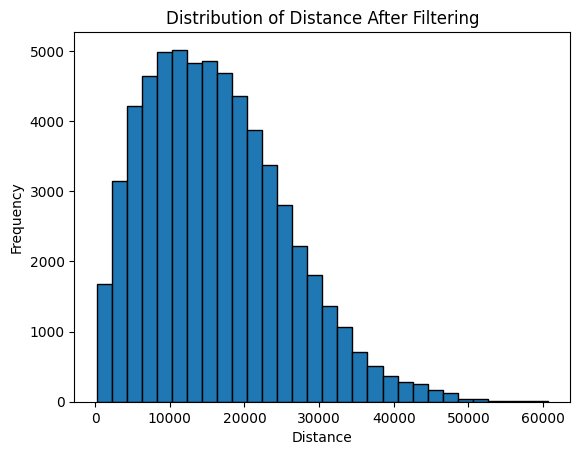

In [12]:
import matplotlib.pyplot as plt

plt.hist(flowdata['distance'], bins=30, edgecolor='k')
plt.title('Distribution of Distance After Filtering')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()


### Doubly Constrained Model

In [13]:
#prepare the variables
x_var= ["distance"]
log_x_var = []

for x in x_var:
    flowdata[f"log_{x}"] = np.log(flowdata[x])
    log_x_var.append(f"log_{x}")

In [14]:
doubly_formula = 'flows ~ station_destination + station_origin + log_distance - 1'


In [15]:
#run the doubly constrained simulation
doubly_Sim = smf.glm(formula = doubly_formula, data=flowdata, family=sm.families.Poisson()).fit()

In [16]:
print(doubly_Sim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    60658
Model Family:                 Poisson   Df Model:                          797
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.7074e+05
Date:                Fri, 31 Jan 2025   Deviance:                   1.7693e+06
Time:                        12:14:08   Pearson chi2:                 2.47e+06
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [17]:
# add the new coloumn to the dataframe, calculate the estimates, give rounded number because flow of commuters are integers
flowdata["doubly_fitted"] = np.round(doubly_Sim.mu)

In [18]:
#create the new matrix
pivot_flows_updated = flowdata.pivot_table(values ="doubly_fitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
pivot_flows_updated

/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/2983805435.py:2: FutureWarning: The provided callable <function sum at 0x1202e55e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_flows_updated = flowdata.pivot_table(values ="doubly_fitted", index="station_origin", columns = "station_destination",
/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/2983805435.py:2: FutureWarning: The provided callable <function sum at 0x1202e55e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_flows_updated = flowdata.pivot_table(values ="doubly_fitted", index="station_origin", columns = "station_destination",
/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/2983805435.py:2: FutureWarning: The p

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,15.0,15.0,NaN,11.0,1.0,NaN,17.0,...,30.0,3.0,5.0,12.0,NaN,2.0,NaN,2.0,NaN,3747.0
Aldgate,NaN,NaN,2.0,NaN,42.0,NaN,NaN,0.0,NaN,19.0,...,7.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2873.0
Aldgate East,NaN,NaN,2.0,49.0,NaN,NaN,1.0,0.0,NaN,21.0,...,8.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,31.0,33.0,NaN,NaN,NaN,NaN,29.0,...,29.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,5.0,18.0,17.0,NaN,3.0,NaN,NaN,22.0,...,21.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [19]:
CalcRSquared(flowdata["flows"],flowdata["doubly_fitted"])

np.float64(0.4077003472409518)

In [20]:
CalcRMSE(flowdata["flows"],flowdata["doubly_fitted"])

101.3

In [21]:
# adding negative exponential
doubly_formula2 = "flows ~ station_origin + station_destination + distance -1"
doubly_Sim2 = smf.glm(formula=doubly_formula2, data = flowdata, family = sm.families.Poisson()).fit()
print(doubly_Sim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    60658
Model Family:                 Poisson   Df Model:                          797
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Fri, 31 Jan 2025   Deviance:                   1.5299e+06
Time:                        12:19:18   Pearson chi2:                 2.02e+06
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [22]:
flowdata["doublysim1"] = np.round(doubly_Sim.mu)
flowdata["doublysim2"] = np.round(doubly_Sim2.mu,0)

In [23]:
CalcRSquared(flowdata["flows"],flowdata["doublysim2"])

np.float64(0.49785541411170725)

In [24]:
CalcRMSE(flowdata["flows"],flowdata["doublysim2"])

93.368

## Iteration

In [25]:
# create the Oi and Dj columns:
O_i = pd.DataFrame(flowdata.groupby(["station_origin"])["flows"].agg("sum"))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
flowdata = flowdata.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flowdata.groupby(["station_destination"])["flows"].agg("sum"))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
flowdata = flowdata.merge(D_j, on = "station_destination", how = "left" )

flowdata

,station_origin,station_destination,flows,population,jobs,distance,log_distance,doubly_fitted,doublysim1,doublysim2,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003504,55.0,55.0,77.0,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049012,2.0,2.0,3.0,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236275,3.0,3.0,4.0,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534348,77.0,77.0,112.0,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709274,45.0,45.0,48.0,599,15428
...,...,...,...,...,...,...,...,...,...,...,...,...
61451,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503144,257.0,257.0,185.0,7892,3342
61452,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071245,152.0,152.0,176.0,7892,5487
61453,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162905,20.0,20.0,27.0,7892,400
61454,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585832,115.0,115.0,132.0,7892,893


In [26]:
print(doubly_Sim2.params)

station_origin[Abbey Road]                 1.354150
station_origin[Acton Central]              2.965314
station_origin[Acton Town]                 2.780711
station_origin[Aldgate]                    1.537233
station_origin[Aldgate East]               1.625544
                                             ...   
station_destination[T.Woodford]            0.556487
station_destination[T.Woodgrange Park]     0.401733
station_destination[T.Woodside Park]       1.106866
station_destination[T.Woolwich Arsenal]    3.493220
distance                                  -0.000154
Length: 798, dtype: float64


In [27]:

beta = -doubly_Sim2.params[-1]

print(beta)

0.00015436969215751494


/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/3324711618.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -doubly_Sim2.params[-1]


In [28]:
def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_column="Ai_new", Bj_column="Bj_new", tolerance=0.001):
    # Initialize the relevant variables
    Oi_data = pd[[orig_field, Oi_field]]
    Dj_data = pd[[dest_field, Dj_field]]    

    # Calculate beta_cij based on the chosen cost function
    if cost_function.lower() in ['power', 'pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))  # Power function
    elif cost_function.lower() in ['exponential', 'exp']:
        beta_cij = np.exp(beta * pd[cij_field])  # Exponential function
    else:
        raise ValueError("Invalid cost function, choose 'exp' or 'pow'")

    # Set up the parameters for the iteration
    convergence = 1
    iteration_count = 0
    
    # Run the iteration until we hit the convergence threshold
    while convergence > tolerance:
        if iteration_count == 0:
            # Initial guess for Ai and Bj (assuming Bj starts as 1)
            Oi_data = Oi_data.assign(Ai = Dj_data[Dj_field] * beta_cij)
            Ai_values = 1.0 / Oi_data.groupby(orig_field)['Ai'].sum().to_frame()
            Oi_data = Oi_data.merge(Ai_values, left_on=orig_field, right_index=True, suffixes=('', '_old'))
            Oi_data.drop('Ai', axis=1, inplace=True)  # Drop the temporary Ai column
            
            # Use the calculated Ai values to compute Bj
            Dj_data = Dj_data.assign(Bj = Oi_data['Ai_old'] * Oi_data[Oi_field] * beta_cij)
            Bj_values = 1.0 / Dj_data.groupby(dest_field)['Bj'].sum().to_frame()
            Dj_data = Dj_data.merge(Bj_values, left_on=dest_field, right_index=True, suffixes=('', '_old'))
            Dj_data.drop('Bj', axis=1, inplace=True)  # Drop the temporary Bj column
            
            iteration_count += 1
        else:
            # Recalculate Ai and Bj iteratively
            Oi_data['Ai'] = Dj_data['Bj_old'] * Dj_data[Dj_field] * beta_cij
            Ai_values = 1.0 / Oi_data.groupby(orig_field)['Ai'].sum().to_frame()
            Oi_data.drop('Ai', axis=1, inplace=True)
            Oi_data = Oi_data.merge(Ai_values, left_on=orig_field, right_index=True)
            Oi_data['diff'] = np.abs((Oi_data['Ai_old'] - Oi_data['Ai']) / Oi_data['Ai_old'])
            Oi_data['Ai_old'] = Oi_data['Ai']
            Oi_data.drop('Ai', axis=1, inplace=True)

            Dj_data['Bj'] = Oi_data['Ai_old'] * Oi_data[Oi_field] * beta_cij
            Bj_values = 1.0 / Dj_data.groupby(dest_field)['Bj'].sum().to_frame()
            Dj_data.drop('Bj', axis=1, inplace=True)
            Dj_data = Dj_data.merge(Bj_values, left_on=dest_field, right_index=True)
            Dj_data['diff'] = np.abs((Dj_data['Bj_old'] - Dj_data['Bj']) / Dj_data['Bj_old'])
            Dj_data['Bj_old'] = Dj_data['Bj']
            Dj_data.drop('Bj', axis=1, inplace=True)

            convergence = max(Oi_data['diff'].sum(), Dj_data['diff'].sum())
            
            # Print out the convergence status for this iteration
            print(f"Iteration: {iteration_count}, Convergence: {convergence}")
            iteration_count += 1

    # After converging, assign the final Ai_old and Bj_old back to the dataframe and return it
    pd[Ai_column] = Oi_data['Ai_old']
    pd[Bj_column] = Dj_data['Bj_old']
    return pd


In [29]:
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
flowdata2 = balance_doubly_constrained(flowdata, 'station_origin', 'station_destination', 'O_i', 'D_j', 'distance', -beta, 'exponential', 'Ai_column', 'Bj_column')

# Now predict the model again using the new Ai and Dj fields.
flowdata2['est_exp'] = np.round(flowdata2['O_i'] * flowdata2['Ai_column'] * flowdata2['D_j'] * flowdata2['Bj_column'] * 
                                   np.exp(flowdata2['distance'] * -beta))

# Check out the matrix
pd.pivot_table(flowdata2, values='est_exp', index='station_origin', columns='station_destination', fill_value=0, aggfunc=sum, margins=True)


Iteration: 1, Convergence: 4971.153596493342
Iteration: 2, Convergence: 1512.042600860216
Iteration: 3, Convergence: 598.6293612968292
Iteration: 4, Convergence: 261.8341372680918
Iteration: 5, Convergence: 123.13301895033472
Iteration: 6, Convergence: 60.83750309789317
Iteration: 7, Convergence: 30.857521277607663
Iteration: 8, Convergence: 15.804418239454206
Iteration: 9, Convergence: 8.153894711873399
Iteration: 10, Convergence: 4.245904809475818
Iteration: 11, Convergence: 2.2298989795946316
Iteration: 12, Convergence: 1.170664507359522
Iteration: 13, Convergence: 0.6144081808007796
Iteration: 14, Convergence: 0.32240618470051935
Iteration: 15, Convergence: 0.1691677035329694
Iteration: 16, Convergence: 0.08875254865281436
Iteration: 17, Convergence: 0.046559542545254476
Iteration: 18, Convergence: 0.024424296209088578
Iteration: 19, Convergence: 0.012812647274237783
Iteration: 20, Convergence: 0.0067213838731929945
Iteration: 21, Convergence: 0.0035262543120045987
Iteration: 22, C

/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/3593159284.py:9: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.pivot_table(flowdata2, values='est_exp', index='station_origin', columns='station_destination', fill_value=0, aggfunc=sum, margins=True)
/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/3593159284.py:9: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.pivot_table(flowdata2, values='est_exp', index='station_origin', columns='station_destination', fill_value=0, aggfunc=sum, margins=True)
/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/3593159284.py:9: Fu

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,603.0
Acton Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1221.0
Acton Town,0.0,0.0,0.0,11.0,10.0,0.0,17.0,0.0,0.0,12.0,...,40.0,4.0,2.0,19.0,0.0,0.0,0.0,1.0,0.0,3752.0
Aldgate,0.0,0.0,1.0,0.0,32.0,0.0,0.0,0.0,0.0,23.0,...,7.0,0.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,2883.0
Aldgate East,0.0,0.0,2.0,38.0,0.0,0.0,0.0,0.0,0.0,24.0,...,7.0,1.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0.0,0.0,2.0,38.0,44.0,0.0,0.0,0.0,0.0,25.0,...,7.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,4862.0
Woodgrange Park,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,528.0
Woodside Park,0.0,0.0,2.0,17.0,15.0,0.0,0.0,0.0,0.0,25.0,...,10.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3093.0


In [30]:
flowdata2

,station_origin,station_destination,flows,population,jobs,distance,log_distance,doubly_fitted,doublysim1,doublysim2,O_i,D_j,Ai_column,Bj_column,est_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003504,55.0,55.0,77.0,599,78549,0.000008,0.743537,77.0
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049012,2.0,2.0,3.0,599,442,0.000008,4.880997,3.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236275,3.0,3.0,4.0,599,665,0.000008,2.138565,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534348,77.0,77.0,112.0,599,58772,0.000008,0.904224,112.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709274,45.0,45.0,48.0,599,15428,0.000008,0.946081,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61451,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503144,257.0,257.0,185.0,7892,3342,0.000017,3.211829,185.0
61452,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071245,152.0,152.0,176.0,7892,5487,0.000017,0.899193,176.0
61453,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162905,20.0,20.0,27.0,7892,400,0.000017,2.118110,27.0
61454,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585832,115.0,115.0,132.0,7892,893,0.000017,2.467993,132.0


In [31]:
pivot_table2 = pd.pivot_table(flowdata2, values='est_exp', index='station_origin', columns='station_destination', fill_value=0, aggfunc=sum, margins=True)

pivot_table2.to_csv('pivot_table2.csv')

/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/2004814698.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_table2 = pd.pivot_table(flowdata2, values='est_exp', index='station_origin', columns='station_destination', fill_value=0, aggfunc=sum, margins=True)
/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipykernel_90437/2004814698.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_table2 = pd.pivot_table(flowdata2, values='est_exp', index='station_origin', columns='station_destination', fill_value=0, aggfunc=sum, margins=True)
/var/folders/8v/w5v659h53kx9q2bmq249f6hc0000gn/T/ipyke

##  calculate the max and min flow for stations

In [32]:
df_max1 = flowdata2[['station_origin', 'station_destination', 'flows']].sort_values(by='flows', ascending=False).head(20)
df_min1 = flowdata2[['station_origin', 'station_destination', 'flows']].sort_values(by='flows', ascending=True).head(10)

print(df_max1)
print(df_min1)


          station_origin       station_destination  flows
55932           Waterloo         Bank and Monument  15946
55957           Waterloo              Canary Wharf   8085
50079          Stratford          Liverpool Street   6946
32642      London Bridge              Canary Wharf   6165
54809           Victoria             Oxford Circus   5181
8541        Canada Water              Canary Wharf   4030
49932          Stratford              Canary Wharf   3875
32392   Liverpool Street                Farringdon   3755
18958      Finsbury Park      Highbury & Islington   3659
8661        Canada Water             London Bridge   3202
27854             Ilford                 Stratford   3080
8817        Canary Wharf         Bank and Monument   2643
54881           Victoria             Warren Street   2599
56088           Waterloo             Oxford Circus   2425
6946             Brixton             Oxford Circus   2411
18978      Finsbury Park  King's Cross St. Pancras   2403
2596   Bank an

##  calculate the max and min flow for stations, for txhe estimations

In [34]:
df_max2 = flowdata2[['station_origin', 'station_destination', 'est_exp', 'flows','Ai_column','Bj_column']].sort_values(by='est_exp', ascending=False).head(20)
df_min2 = flowdata2[['station_origin', 'station_destination', 'est_exp', 'flows','Ai_column','Bj_column']].sort_values(by='est_exp', ascending=True).head(10)

print(df_max2)
print(df_min2)


         station_origin station_destination  est_exp  flows  Ai_column  \
55932          Waterloo   Bank and Monument   4557.0  15946   0.000002   
49932         Stratford        Canary Wharf   3747.0   3875   0.000003   
27854            Ilford           Stratford   3162.0   3080   0.000045   
49895         Stratford   Bank and Monument   2998.0   1138   0.000003   
32617     London Bridge   Bank and Monument   2962.0    445   0.000002   
32315  Liverpool Street   Bank and Monument   2921.0    812   0.000002   
56057          Waterloo    Liverpool Street   2834.0   1571   0.000002   
56088          Waterloo       Oxford Circus   2729.0   2425   0.000002   
56158          Waterloo            Victoria   2450.0    285   0.000002   
50079         Stratford    Liverpool Street   2417.0   6946   0.000003   
56058          Waterloo       London Bridge   2295.0   1862   0.000002   
8541       Canada Water        Canary Wharf   2134.0   4030   0.000002   
9149       Canning Town        Canary 

In [35]:
df_max1.to_csv('top_10_sim_exp_max1.csv', index=False)
df_min1.to_csv('top_10_sim_exp_min1.csv', index=False)


df_max2.to_csv('top_10_sim_exp_max2.csv', index=False)
df_min2.to_csv('top_10_sim_exp_min2.csv', index=False)

In [36]:
# difference
flowdata2['difference'] = abs(flowdata2['est_exp'] - flowdata2['flows'])

top10 = flowdata2.nlargest(10, "difference")

print(top10[["station_origin", "station_destination", "difference"]])

top10[["station_origin", "station_destination", "difference"]].to_csv("top10_changes.csv", index=False)


         station_origin   station_destination  difference
55932          Waterloo     Bank and Monument     11389.0
55957          Waterloo          Canary Wharf      6136.0
32642     London Bridge          Canary Wharf      4879.0
50079         Stratford      Liverpool Street      4529.0
54809          Victoria         Oxford Circus      3427.0
32392  Liverpool Street            Farringdon      2767.0
18958     Finsbury Park  Highbury & Islington      2681.0
32617     London Bridge     Bank and Monument      2517.0
8661       Canada Water         London Bridge      2230.0
56158          Waterloo              Victoria      2165.0


In [37]:
flowdata2

,station_origin,station_destination,flows,population,jobs,distance,log_distance,doubly_fitted,doublysim1,doublysim2,O_i,D_j,Ai_column,Bj_column,est_exp,difference
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003504,55.0,55.0,77.0,599,78549,0.000008,0.743537,77.0,77.0
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049012,2.0,2.0,3.0,599,442,0.000008,4.880997,3.0,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236275,3.0,3.0,4.0,599,665,0.000008,2.138565,4.0,1.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534348,77.0,77.0,112.0,599,58772,0.000008,0.904224,112.0,111.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709274,45.0,45.0,48.0,599,15428,0.000008,0.946081,48.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61451,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795550,9.503144,257.0,257.0,185.0,7892,3342,0.000017,3.211829,185.0,58.0
61452,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071245,152.0,152.0,176.0,7892,5487,0.000017,0.899193,176.0,432.0
61453,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162905,20.0,20.0,27.0,7892,400,0.000017,2.118110,27.0,21.0
61454,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585832,115.0,115.0,132.0,7892,893,0.000017,2.467993,132.0,51.0


# Scenario A

In [38]:
def scenario_a(row):
    # If the destination station is Canary Wharf, reduce the jobs by half
    if row["station_destination"] == "Canary Wharf":
        val = 0.5 * row["jobs"]
    else:
        val = row["jobs"]
    return val

In [39]:

# Reapply and recalculate senarioA
flowdata2["jobsnew"] = flowdata2.apply(scenario_a, axis=1)

flowdata2['senario_A'] = np.round(
    flowdata2['population'] * flowdata2['Ai_column'] * flowdata2['Bj_column'] *
    np.exp(flowdata2['distance'] * -beta)
)

# Calculate the total flow sum and senarioA sum
flows_sum = flowdata2['flows'].sum()
senario_A_sum = flowdata2['senario_A'].sum()


In [40]:
# Calculate k to scale the senarioA values
k = flows_sum / senario_A_sum

# Calculate senarioA1 by applying the scaling factor k
flowdata2['senario_A1'] = flowdata2['senario_A'] * k

In [41]:
# Calculate the absolute difference between senario_A1 and est_exp
flowdata2["difference_a"] = abs(flowdata2["senario_A1"] - flowdata2["est_exp"])

# Get the top 10 records with the largest differences
top10 = flowdata2.nlargest(10, "difference_a")

# Print relevant information for these top 10 records
print(top10[["station_origin", "station_destination", "difference_a"]])

         station_origin station_destination  difference_a
43508           Romford        Emerson Park      771101.5
6780          Brentwood           Shenfield      770634.5
55932          Waterloo   Bank and Monument        4557.0
49932         Stratford        Canary Wharf        3747.0
27854            Ilford           Stratford        3162.0
49895         Stratford   Bank and Monument        2998.0
32617     London Bridge   Bank and Monument        2962.0
32315  Liverpool Street   Bank and Monument        2921.0
56057          Waterloo    Liverpool Street        2834.0
56088          Waterloo       Oxford Circus        2729.0


In [136]:
top10[["station_origin", "station_destination", "difference_a"]].to_csv("top10_difference_a.csv", index=False)

# Scenario B

In [137]:
# Scenario B, use two beta, 0.003 and 0.005

In [138]:
beta_b1=0.0003


In [139]:
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
flowdata2 = balance_doubly_constrained(flowdata, 'station_origin', 'station_destination', 'O_i', 'D_j', 'distance', -beta_b1, 'exponential', 'Ai_column_b1', 'Bj_column_b1')

# Now predict the model again using the new Ai and Dj fields.
flowdata2['scenario_b1'] = np.round(flowdata2['O_i'] * flowdata2['Ai_column_b1'] * flowdata2['D_j'] * flowdata2['Bj_column_b1'] * 
                                   np.exp(flowdata2['distance'] * -beta_b1))


Iteration: 1, Convergence: 6092.036832392171
Iteration: 2, Convergence: 2542.945374635538
Iteration: 3, Convergence: 1382.1440123421926
Iteration: 4, Convergence: 888.889345438606
Iteration: 5, Convergence: 597.1027240469382
Iteration: 6, Convergence: 405.9302503226119
Iteration: 7, Convergence: 276.516449597263
Iteration: 8, Convergence: 188.09514190655403
Iteration: 9, Convergence: 127.73461413725371
Iteration: 10, Convergence: 86.64843910792419
Iteration: 11, Convergence: 58.786094423718204
Iteration: 12, Convergence: 39.959198027748066
Iteration: 13, Convergence: 27.254511992557674
Iteration: 14, Convergence: 18.668411602670066
Iteration: 15, Convergence: 12.866582518525728
Iteration: 16, Convergence: 8.92894728097925
Iteration: 17, Convergence: 6.249015443946039
Iteration: 18, Convergence: 4.413466960654405
Iteration: 19, Convergence: 3.135388867758138
Iteration: 20, Convergence: 2.237847156457364
Iteration: 21, Convergence: 1.604155082585688
Iteration: 22, Convergence: 1.15482914

In [141]:
# the difference
flowdata2["difference_b1"] = abs(flowdata2["scenario_b1"] - flowdata2["est_exp"])
top10 = flowdata2.nlargest(10, "difference_b1")
print(top10[["station_origin", "station_destination", "difference_b1"]])

          station_origin   station_destination  difference_b1
36352    North Greenwich          Canary Wharf         1763.0
32315   Liverpool Street     Bank and Monument         1662.0
9149        Canning Town          Canary Wharf         1645.0
49932          Stratford          Canary Wharf         1597.0
32617      London Bridge     Bank and Monument         1556.0
47503        Southfields             Wimbledon         1167.0
2712   Bank and Monument      Liverpool Street         1154.0
8541        Canada Water          Canary Wharf         1154.0
18958      Finsbury Park  Highbury & Islington         1111.0
31922             Leyton             Stratford          997.0


In [142]:
top10[["station_origin", "station_destination", "difference_b1"]].to_csv("top10_difference_b1.csv", index=False)

In [143]:
beta_b2=0.0006

In [146]:
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
flowdata2 = balance_doubly_constrained(flowdata, 'station_origin', 'station_destination', 'O_i', 'D_j', 'distance', -beta_b2, 'exponential', 'Ai_column_b2', 'Bj_column_b2')

# Now predict the model again using the new Ai and Dj fields.
flowdata2['scenario_b2'] = np.round(flowdata2['O_i'] * flowdata2['Ai_column_b2'] * flowdata2['D_j'] * flowdata2['Bj_column_b2'] * 
                                   np.exp(flowdata2['distance'] * -beta_b2))


Iteration: 1, Convergence: 25359.11403320973
Iteration: 2, Convergence: 15734.55609583603
Iteration: 3, Convergence: 10694.955917857977
Iteration: 4, Convergence: 7714.187610620346
Iteration: 5, Convergence: 5843.18570636078
Iteration: 6, Convergence: 4546.651614701402
Iteration: 7, Convergence: 3595.2010618822983
Iteration: 8, Convergence: 2868.6770986370047
Iteration: 9, Convergence: 2307.6293574397337
Iteration: 10, Convergence: 1865.9159277693752
Iteration: 11, Convergence: 1515.9103939572385
Iteration: 12, Convergence: 1236.993397821343
Iteration: 13, Convergence: 1013.4312316262009
Iteration: 14, Convergence: 833.2091355502163
Iteration: 15, Convergence: 686.9602243855308
Iteration: 16, Convergence: 574.9658402604895
Iteration: 17, Convergence: 489.01156639547025
Iteration: 18, Convergence: 416.86866095729175
Iteration: 19, Convergence: 355.3599955185493
Iteration: 20, Convergence: 302.3139591055281
Iteration: 21, Convergence: 256.0313598036431
Iteration: 22, Convergence: 216.030

In [147]:
# the difference
flowdata2["difference_b2"] = abs(flowdata2["scenario_b2"] - flowdata2["est_exp"])
top10 = flowdata2.nlargest(10, "difference_b2")
print(top10[["station_origin", "station_destination", "difference_b2"]])

          station_origin   station_destination  difference_b2
36352    North Greenwich          Canary Wharf         4970.0
9149        Canning Town          Canary Wharf         4642.0
32617      London Bridge     Bank and Monument         4580.0
32315   Liverpool Street     Bank and Monument         4451.0
18958      Finsbury Park  Highbury & Islington         3622.0
7013             Brixton              Vauxhall         2993.0
2712   Bank and Monument      Liverpool Street         2990.0
47503        Southfields             Wimbledon         2733.0
31922             Leyton             Stratford         2575.0
54614           Vauxhall              Victoria         2546.0


In [148]:
top10[["station_origin", "station_destination", "difference_b2"]].to_csv("top10_difference_b2.csv", index=False)